# Statystyczna Analiza Danych Chorób Serca

Kompleksowa analiza zbioru danych `heart_cleveland_upload.csv` obejmująca:

1. Wczytanie i wstępne przetwarzanie danych
2. Statystyki opisowe
3. Analiza korelacji
4. **Prosta regresja liniowa z wzorami**
5. Przygotowanie dla modeli ML (XGBoost/Random Forest)
6. Wizualizacja danych


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import warnings
import os
warnings.filterwarnings('ignore')

output_dir = 'heart_output'
os.makedirs(output_dir, exist_ok=True)

plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

df = pd.read_csv('datasets/heart_cleveland_upload.csv')
print("Dane załadowane pomyślnie!")
print(f"Rozmiar zbioru danych: {df.shape}")
print("\nPierwsze 5 wierszy:")
df.head()

Dane załadowane pomyślnie!
Rozmiar zbioru danych: (297, 14)

Pierwsze 5 wierszy:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


## 1. Import bibliotek i wczytanie danych


## 2. Przetwarzanie wstępne - czyszczenie i obsługa brakujących danych


In [3]:
def clean_and_handle_missing_data(df):
    print("=== ANALIZA JAKOŚCI DANYCH ===\n")

    print("1. Informacje ogólne:")
    print(f"   - Wiersze: {df.shape[0]}")
    print(f"   - Kolumny: {df.shape[1]}")
    print(f"   - Typy danych:\n{df.dtypes}")

    print("\n2. Analiza brakujących wartości:")
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100
    missing_df = pd.DataFrame({
        'Kolumna': missing_values.index,
        'Brakujące wartości': missing_values.values,
        'Procent': missing_percentage.values
    })
    print(missing_df[missing_df['Brakujące wartości'] > 0])

    if missing_values.sum() == 0:
        print("   Nie znaleziono brakujących wartości!")

    print("\n3. Analiza duplikatów:")
    duplicates = df.duplicated().sum()
    print(f"   Liczba duplikatów: {duplicates}")

    print("\n4. Analiza zakresów wartości i wartości odstających:")
    df_clean = df.copy()

    for column in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]

        print(f"   {column}:")
        print(f"      Zakres: [{df[column].min():.3f}, {df[column].max():.3f}]")
        print(f"      Wartości odstające: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")

    if duplicates > 0:
        df_clean = df_clean.drop_duplicates()
        print(f"\n5. Usunięto {duplicates} duplikatów")

    def fill_missing_values(df, method='mean'):
        df_filled = df.copy()

        for column in df.columns:
            if df[column].isnull().sum() > 0:
                if method == 'mean':
                    df_filled[column].fillna(df[column].mean(), inplace=True)
                elif method == 'median':
                    df_filled[column].fillna(df[column].median(), inplace=True)

        return df_filled

    if missing_values.sum() > 0:
        df_clean = fill_missing_values(df_clean, method='mean')
        print("6. Wypełniono brakujące wartości średnimi")

    print(f"\n=== DANE PO CZYSZCZENIU ===")
    print(f"Rozmiar: {df_clean.shape}")
    print("Czyszczenie danych zakończone pomyślnie!")

    return df_clean

df_clean = clean_and_handle_missing_data(df)

=== ANALIZA JAKOŚCI DANYCH ===

1. Informacje ogólne:
   - Wiersze: 297
   - Kolumny: 14
   - Typy danych:
age            int64
sex            int64
cp             int64
trestbps       int64
chol           int64
fbs            int64
restecg        int64
thalach        int64
exang          int64
oldpeak      float64
slope          int64
ca             int64
thal           int64
condition      int64
dtype: object

2. Analiza brakujących wartości:
Empty DataFrame
Columns: [Kolumna, Brakujące wartości, Procent]
Index: []
   Nie znaleziono brakujących wartości!

3. Analiza duplikatów:
   Liczba duplikatów: 0

4. Analiza zakresów wartości i wartości odstających:
   age:
      Zakres: [29.000, 77.000]
      Wartości odstające: 0 (0.00%)
   sex:
      Zakres: [0.000, 1.000]
      Wartości odstające: 0 (0.00%)
   cp:
      Zakres: [0.000, 3.000]
      Wartości odstające: 23 (7.74%)
   trestbps:
      Zakres: [94.000, 200.000]
      Wartości odstające: 9 (3.03%)
   chol:
      Zakres: [126.000, 

## 3. Statystyki opisowe


In [4]:
def calculate_descriptive_statistics(df):
    print("=== STATYSTYKI OPISOWE ===\n")

    numeric_columns = df.select_dtypes(include=[np.number]).columns

    stats_dict = {}

    for column in numeric_columns:
        data = df[column]

        stats_dict[column] = {
            'Min': data.min(),
            'Max': data.max(),
            'Zakres': data.max() - data.min(),
            'Średnia': data.mean(),
            'Odch. std': data.std(),
            'Mediana': data.median(),
            'Q1 (25%)': data.quantile(0.25),
            'Q3 (75%)': data.quantile(0.75),
            'IQR': data.quantile(0.75) - data.quantile(0.25),
            'Kwantyl 0.1': data.quantile(0.1),
            'Kwantyl 0.9': data.quantile(0.9),
            'Skośność': data.skew(),
            'Kurtoza': data.kurtosis()
        }

    stats_df = pd.DataFrame(stats_dict).T

    print("Podstawowe statystyki opisowe:")
    print("="*80)

    main_stats = stats_df[['Min', 'Max', 'Zakres', 'Średnia', 'Odch. std', 'Mediana']]
    print(main_stats.round(3))

    print("\n" + "="*80)
    print("Kwartyle i kwantyle:")
    print("="*80)

    quartile_stats = stats_df[['Q1 (25%)', 'Mediana', 'Q3 (75%)', 'IQR', 'Kwantyl 0.1', 'Kwantyl 0.9']]
    print(quartile_stats.round(3))

    print("\n" + "="*80)
    print("Miary kształtu rozkładu:")
    print("="*80)

    shape_stats = stats_df[['Skośność', 'Kurtoza']]
    print(shape_stats.round(3))

    print("\nInterpretacja kształtu:")
    for column in numeric_columns:
        skewness = stats_df.loc[column, 'Skośność']
        kurtosis = stats_df.loc[column, 'Kurtoza']

        if abs(skewness) < 0.5:
            skew_desc = "symetryczny"
        elif skewness > 0.5:
            skew_desc = "prawostronnie skośny (ogon po prawej)"
        else:
            skew_desc = "lewostronnie skośny (ogon po lewej)"

        if abs(kurtosis) < 0.5:
            kurt_desc = "mezokurtyczny (normalny)"
        elif kurtosis > 0.5:
            kurt_desc = "leptokurtyczny (ostry szczyt)"
        else:
            kurt_desc = "platykurtyczny (płaski szczyt)"

        print(f"  {column}: {skew_desc}, {kurt_desc}")

    return stats_df

descriptive_stats = calculate_descriptive_statistics(df_clean)

=== STATYSTYKI OPISOWE ===

Podstawowe statystyki opisowe:
             Min    Max  Zakres  Średnia  Odch. std  Mediana
age         29.0   77.0    48.0   54.542      9.050     56.0
sex          0.0    1.0     1.0    0.677      0.468      1.0
cp           0.0    3.0     3.0    2.158      0.965      2.0
trestbps    94.0  200.0   106.0  131.694     17.763    130.0
chol       126.0  564.0   438.0  247.350     51.998    243.0
fbs          0.0    1.0     1.0    0.145      0.352      0.0
restecg      0.0    2.0     2.0    0.997      0.995      1.0
thalach     71.0  202.0   131.0  149.599     22.942    153.0
exang        0.0    1.0     1.0    0.327      0.470      0.0
oldpeak      0.0    6.2     6.2    1.056      1.166      0.8
slope        0.0    2.0     2.0    0.603      0.618      1.0
ca           0.0    3.0     3.0    0.677      0.939      0.0
thal         0.0    2.0     2.0    0.835      0.957      0.0
condition    0.0    1.0     1.0    0.461      0.499      0.0

Kwartyle i kwantyle:
    

## 4. Analiza korelacji liniowej Pearsona


In [5]:
def analyze_correlations(df):
    print("=== ANALIZA KORELACJI LINIOWEJ PEARSONA ===\n")

    numeric_columns = df.select_dtypes(include=[np.number]).columns

    correlation_matrix = df[numeric_columns].corr(method='pearson')

    print("1. Macierz korelacji Pearsona:")
    print("="*50)
    print(correlation_matrix.round(3))

    print("\n2. Silne korelacje (|r| > 0.5):")
    print("="*50)

    strong_correlations = []
    for i, col1 in enumerate(numeric_columns):
        for j, col2 in enumerate(numeric_columns):
            if i < j:
                corr_coef = correlation_matrix.loc[col1, col2]
                if abs(corr_coef) > 0.5:
                    _, p_value = pearsonr(df[col1], df[col2])
                    strong_correlations.append({
                        'Zmienna 1': col1,
                        'Zmienna 2': col2,
                        'Korelacja': corr_coef,
                        'p-wartość': p_value,
                        'Istotna (p<0.05)': 'Tak' if p_value < 0.05 else 'Nie'
                    })

    if strong_correlations:
        strong_corr_df = pd.DataFrame(strong_correlations)
        strong_corr_df = strong_corr_df.sort_values('Korelacja', key=abs, ascending=False)
        print(strong_corr_df)
    else:
        print("Brak korelacji z |r| > 0.5")

    print("\n3. Korelacje ze zmienną condition (choroba serca):")
    print("="*40)

    if 'condition' in numeric_columns:
        quality_correlations = []
        for column in numeric_columns:
            if column != 'condition':
                corr_coef, p_value = pearsonr(df[column], df['condition'])
                quality_correlations.append({
                    'Zmienna': column,
                    'Korelacja z condition': corr_coef,
                    'p-wartość': p_value,
                    'Istotna (p<0.05)': 'Tak' if p_value < 0.05 else 'Nie'
                })

        quality_corr_df = pd.DataFrame(quality_correlations)
        quality_corr_df = quality_corr_df.sort_values('Korelacja z condition', key=abs, ascending=False)
        print(quality_corr_df.round(4))
    else:
        quality_corr_df = None

    print("\n4. Interpretacja siły korelacji:")
    print("="*40)
    print("0.0 - 0.2: bardzo słaba")
    print("0.2 - 0.4: słaba")
    print("0.4 - 0.6: umiarkowana")
    print("0.6 - 0.8: silna")
    print("0.8 - 1.0: bardzo silna")

    return correlation_matrix, strong_corr_df if strong_correlations else None, quality_corr_df

correlation_matrix, strong_correlations_df, condition_correlations_df = analyze_correlations(df_clean)

=== ANALIZA KORELACJI LINIOWEJ PEARSONA ===

1. Macierz korelacji Pearsona:
             age    sex     cp  trestbps   chol    fbs  restecg  thalach  \
age        1.000 -0.092  0.110     0.290  0.203  0.132    0.150   -0.395   
sex       -0.092  1.000  0.009    -0.066 -0.198  0.039    0.034   -0.060   
cp         0.110  0.009  1.000    -0.037  0.072 -0.058    0.064   -0.339   
trestbps   0.290 -0.066 -0.037     1.000  0.132  0.181    0.149   -0.049   
chol       0.203 -0.198  0.072     0.132  1.000  0.013    0.165   -0.000   
fbs        0.132  0.039 -0.058     0.181  0.013  1.000    0.069   -0.008   
restecg    0.150  0.034  0.064     0.149  0.165  0.069    1.000   -0.072   
thalach   -0.395 -0.060 -0.339    -0.049 -0.000 -0.008   -0.072    1.000   
exang      0.096  0.144  0.378     0.067  0.059 -0.001    0.082   -0.384   
oldpeak    0.197  0.107  0.203     0.191  0.039  0.008    0.114   -0.348   
slope      0.159  0.033  0.151     0.121 -0.009  0.048    0.135   -0.389   
ca         0

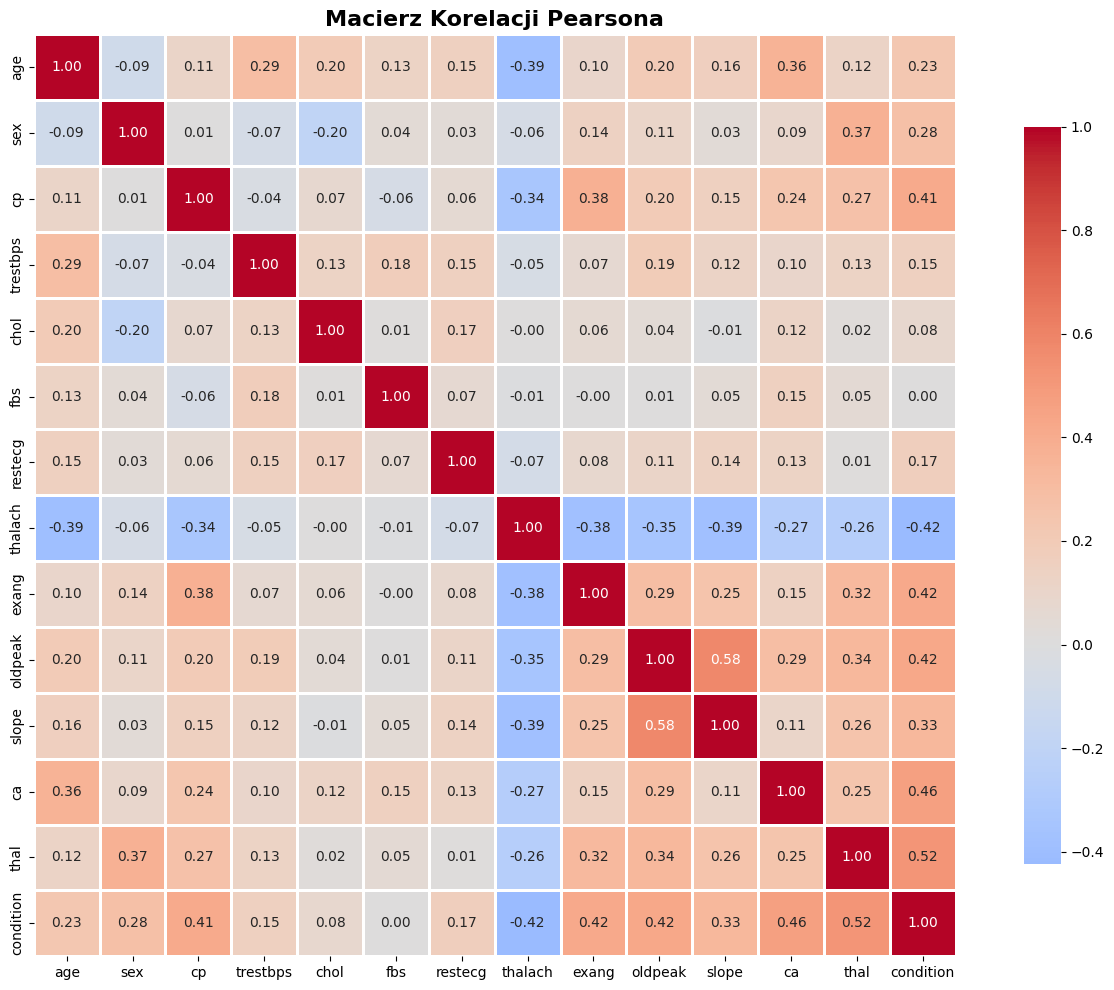

✓ Wykres zapisany: heart_output/correlation_heatmap.png


In [6]:
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Macierz Korelacji Pearsona', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{output_dir}/correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✓ Wykres zapisany: {output_dir}/correlation_heatmap.png")

## 5. Prosta regresja liniowa


In [7]:
def perform_linear_regression_analysis(df):
    print("=== PROSTA REGRESJA LINIOWA ===\n")

    numeric_columns = df.select_dtypes(include=[np.number]).columns

    print("1. Regresja liniowa: predykcja condition (sklearn)")
    print("="*50)

    correlations_with_condition = []
    for col in numeric_columns:
        if col != 'condition' and 'condition' in df.columns:
            corr = df[col].corr(df['condition'])
            correlations_with_condition.append((col, abs(corr), corr))

    if not correlations_with_condition:
        print("Brak zmiennej condition - używam pierwszych par zmiennych")
        regression_pairs = [('age', 'trestbps'), ('age', 'chol'), ('trestbps', 'chol')]

        for x_col, y_col in regression_pairs[:3]:
            print(f"\n{x_col} → {y_col}:")
            print("-" * 40)

            X = df[[x_col]]
            y = df[y_col]

            model = LinearRegression()
            model.fit(X, y)

            y_pred = model.predict(X)

            slope = model.coef_[0]
            intercept = model.intercept_
            r_squared = r2_score(y, y_pred)

            print(f"   Wzór regresji liniowej:")
            print(f"   {y_col} = {intercept:.4f} + {slope:.4f} × {x_col}")
            print(f"   R² = {r_squared:.4f}")

        return [], None, x_col

    correlations_with_condition.sort(key=lambda x: x[1], reverse=True)

    top_predictors = correlations_with_condition[:3]

    for i, (predictor, abs_corr, corr) in enumerate(top_predictors, 1):
        print(f"\n{i}. {predictor} → condition (r = {corr:.3f}):")
        print("-" * 40)

        X = df[[predictor]]
        y = df['condition']

        model = LinearRegression()
        model.fit(X, y)

        y_pred = model.predict(X)

        slope = model.coef_[0]
        intercept = model.intercept_
        r_squared = r2_score(y, y_pred)
        mse = mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)

        print(f"   Wzór regresji liniowej:")
        print(f"   condition = {intercept:.4f} + {slope:.4f} × {predictor}")
        print(f"   ")
        print(f"   Parametry (sklearn):")
        print(f"   • Współczynnik kierunkowy (slope): a = {slope:.4f}")
        print(f"   • Wyraz wolny (intercept): b = {intercept:.4f}")
        print(f"   • Współczynnik korelacji: r = {corr:.4f}")
        print(f"   • Współczynnik determinacji: R² = {r_squared:.4f} ({r_squared*100:.1f}% wyjaśnionej wariancji)")
        print(f"   • Błąd średniokwadratowy (MSE): {mse:.4f}")
        print(f"   • Pierwiastek z MSE (RMSE): {rmse:.4f}")
        print(f"   ✓ Model score: {model.score(X, y):.4f}")

        if corr > 0:
            print(f"   ✓ Zależność dodatnia: wzrost {predictor} o 1 jednostkę → wzrost condition o {slope:.4f}")
        else:
            print(f"   ✓ Zależność ujemna: wzrost {predictor} o 1 jednostkę → spadek condition o {abs(slope):.4f}")

    print(f"\n" + "="*50)
    print("2. Regresja wielokrotna (multiple regression) - top 3 predyktory:")
    print("="*50)

    top_3_vars = [x[0] for x in top_predictors]
    X_multi = df[top_3_vars]
    y = df['condition']

    model_multi = LinearRegression()
    model_multi.fit(X_multi, y)

    y_pred_multi = model_multi.predict(X_multi)
    r_squared_multi = r2_score(y, y_pred_multi)
    mse_multi = mean_squared_error(y, y_pred_multi)
    rmse_multi = np.sqrt(mse_multi)

    print(f"Regresja wielokrotna dla top 3 predyktorów:")
    formula = f"condition = {model_multi.intercept_:.4f}"
    for var, coef in zip(top_3_vars, model_multi.coef_):
        formula += f" + {coef:.4f}×{var}"
    print(formula)

    print(f"R² = {r_squared_multi:.4f} ({r_squared_multi*100:.2f}% wyjaśnionej wariancji)")
    print(f"MSE = {mse_multi:.4f}, RMSE = {rmse_multi:.4f}")

    print(f"\n3. Przygotowanie danych dla zaawansowanych modeli ML:")
    print("="*50)
    print("   ✓ Regresja liniowa wykonana (sklearn) - podstawa do porównania")
    print("   ✓ Dane przygotowane do modeli XGBoost/Random Forest")
    print("   ✓ Najlepszy predyktor liniowy:", top_predictors[0][0])

    return correlations_with_condition, model_multi, top_predictors[0][0]

feature_ranking, multi_model, best_predictor = perform_linear_regression_analysis(df_clean)

=== PROSTA REGRESJA LINIOWA ===

1. Regresja liniowa: predykcja condition (sklearn)

1. thal → condition (r = 0.521):
----------------------------------------
   Wzór regresji liniowej:
   condition = 0.2344 + 0.2717 × thal
   
   Parametry (sklearn):
   • Współczynnik kierunkowy (slope): a = 0.2717
   • Wyraz wolny (intercept): b = 0.2344
   • Współczynnik korelacji: r = 0.5205
   • Współczynnik determinacji: R² = 0.2709 (27.1% wyjaśnionej wariancji)
   • Błąd średniokwadratowy (MSE): 0.1812
   • Pierwiastek z MSE (RMSE): 0.4256
   ✓ Model score: 0.2709
   ✓ Zależność dodatnia: wzrost thal o 1 jednostkę → wzrost condition o 0.2717

2. ca → condition (r = 0.463):
----------------------------------------
   Wzór regresji liniowej:
   condition = 0.2946 + 0.2463 × ca
   
   Parametry (sklearn):
   • Współczynnik kierunkowy (slope): a = 0.2463
   • Wyraz wolny (intercept): b = 0.2946
   • Współczynnik korelacji: r = 0.4632
   • Współczynnik determinacji: R² = 0.2145 (21.5% wyjaśnionej war

## 6. Przygotowanie dla zaawansowanych modeli ML


In [8]:
def prepare_for_ml_models(df):
    print("=== PRZYGOTOWANIE DANYCH DLA ZAAWANSOWANYCH MODELI ML ===\n")

    numeric_columns = df.select_dtypes(include=[np.number]).columns

    print("1. Ranking cech dla modeli ML:")
    print("="*50)

    if 'condition' in df.columns:
        correlations_with_target = []
        for col in numeric_columns:
            if col != 'condition':
                corr = df[col].corr(df['condition'])
                correlations_with_target.append((col, abs(corr), corr))

        correlations_with_target.sort(key=lambda x: x[1], reverse=True)

        print("Ranking zmiennych według siły korelacji z condition:")
        for i, (predictor, abs_corr, corr) in enumerate(correlations_with_target, 1):
            direction = "dodatnia" if corr > 0 else "ujemna"
            strength = "bardzo silna" if abs_corr > 0.7 else "silna" if abs_corr > 0.5 else "umiarkowana" if abs_corr > 0.3 else "słaba"
            print(f"   {i:2d}. {predictor:20s}: r = {corr:6.3f} ({direction:8s}, {strength})")

        print(f"\n2. Charakterystyka zbioru danych:")
        print("="*50)
        print(f"   • Liczba próbek: {len(df)}")
        print(f"   • Liczba cech: {len(numeric_columns)-1}")
        print(f"   • Zmienna docelowa: condition (zakres: {df['condition'].min()}-{df['condition'].max()})")

        print(f"\n   • Rozkład klas condition:")
        condition_counts = df['condition'].value_counts().sort_index()
        for condition, count in condition_counts.items():
            percentage = (count / len(df)) * 100
            print(f"     Condition {condition}: {count:4d} próbek ({percentage:5.1f}%)")

        top_3_predictors = [x[0] for x in correlations_with_target[:3]]
    else:
        correlations_with_target = []
        top_3_predictors = list(numeric_columns[:3])
        print("   Brak zmiennej condition - analiza ogólna")

    print(f"\n3. Analiza multikolinearności:")
    print("="*50)

    predictor_columns = [col for col in numeric_columns if col != 'condition']
    high_correlations = []

    for i, col1 in enumerate(predictor_columns):
        for j, col2 in enumerate(predictor_columns):
            if i < j:
                corr = df[col1].corr(df[col2])
                if abs(corr) > 0.7:
                    high_correlations.append((col1, col2, corr))

    if high_correlations:
        print("   Silnie skorelowane pary zmiennych (|r| > 0.7):")
        for col1, col2, corr in sorted(high_correlations, key=lambda x: abs(x[2]), reverse=True):
            print(f"     {col1} ↔ {col2}: r = {corr:.3f}")
        print("   UWAGA: Rozważ usunięcie jednej ze zmiennych z każdej pary")
    else:
        print("   Brak silnych korelacji między predyktorami (|r| > 0.7)")

    print(f"\n4. Rekomendacje dla modeli ML:")
    print("="*50)
    print("   ✓ Dane są gotowe do modelowania ML")
    print("   ✓ Brak brakujących wartości")
    print(f"   ✓ Top 3 predyktory: {', '.join(top_3_predictors)}")
    print("   ✓ Random Forest: może obsłużyć wszystkie cechy")
    print("   ✓ XGBoost: może obsłużyć wszystkie cechy")

    if len(high_correlations) > 0:
        print("   ⚠ Uwaga: wykryto multikolinearność - może wpłynąć na interpretację")

    print(f"\n   Gotowy zbiór danych dla treningu modeli:")
    print(f"   • X (cechy): {len(predictor_columns)} zmiennych")
    print(f"   • y (cel): condition / wybrana zmienna")
    print(f"   • Rekomendowany podział: 80% trening, 20% test")

    return correlations_with_target, top_3_predictors

ml_features, top_features = prepare_for_ml_models(df_clean)

=== PRZYGOTOWANIE DANYCH DLA ZAAWANSOWANYCH MODELI ML ===

1. Ranking cech dla modeli ML:
Ranking zmiennych według siły korelacji z condition:
    1. thal                : r =  0.521 (dodatnia, silna)
    2. ca                  : r =  0.463 (dodatnia, umiarkowana)
    3. oldpeak             : r =  0.424 (dodatnia, umiarkowana)
    4. thalach             : r = -0.424 (ujemna  , umiarkowana)
    5. exang               : r =  0.421 (dodatnia, umiarkowana)
    6. cp                  : r =  0.409 (dodatnia, umiarkowana)
    7. slope               : r =  0.333 (dodatnia, umiarkowana)
    8. sex                 : r =  0.278 (dodatnia, słaba)
    9. age                 : r =  0.227 (dodatnia, słaba)
   10. restecg             : r =  0.166 (dodatnia, słaba)
   11. trestbps            : r =  0.153 (dodatnia, słaba)
   12. chol                : r =  0.080 (dodatnia, słaba)
   13. fbs                 : r =  0.003 (dodatnia, słaba)

2. Charakterystyka zbioru danych:
   • Liczba próbek: 297
   • Lic

## 7. Wizualizacja danych

### 7.1 Wykresy kołowe - rozkład zmiennych kategorycznych


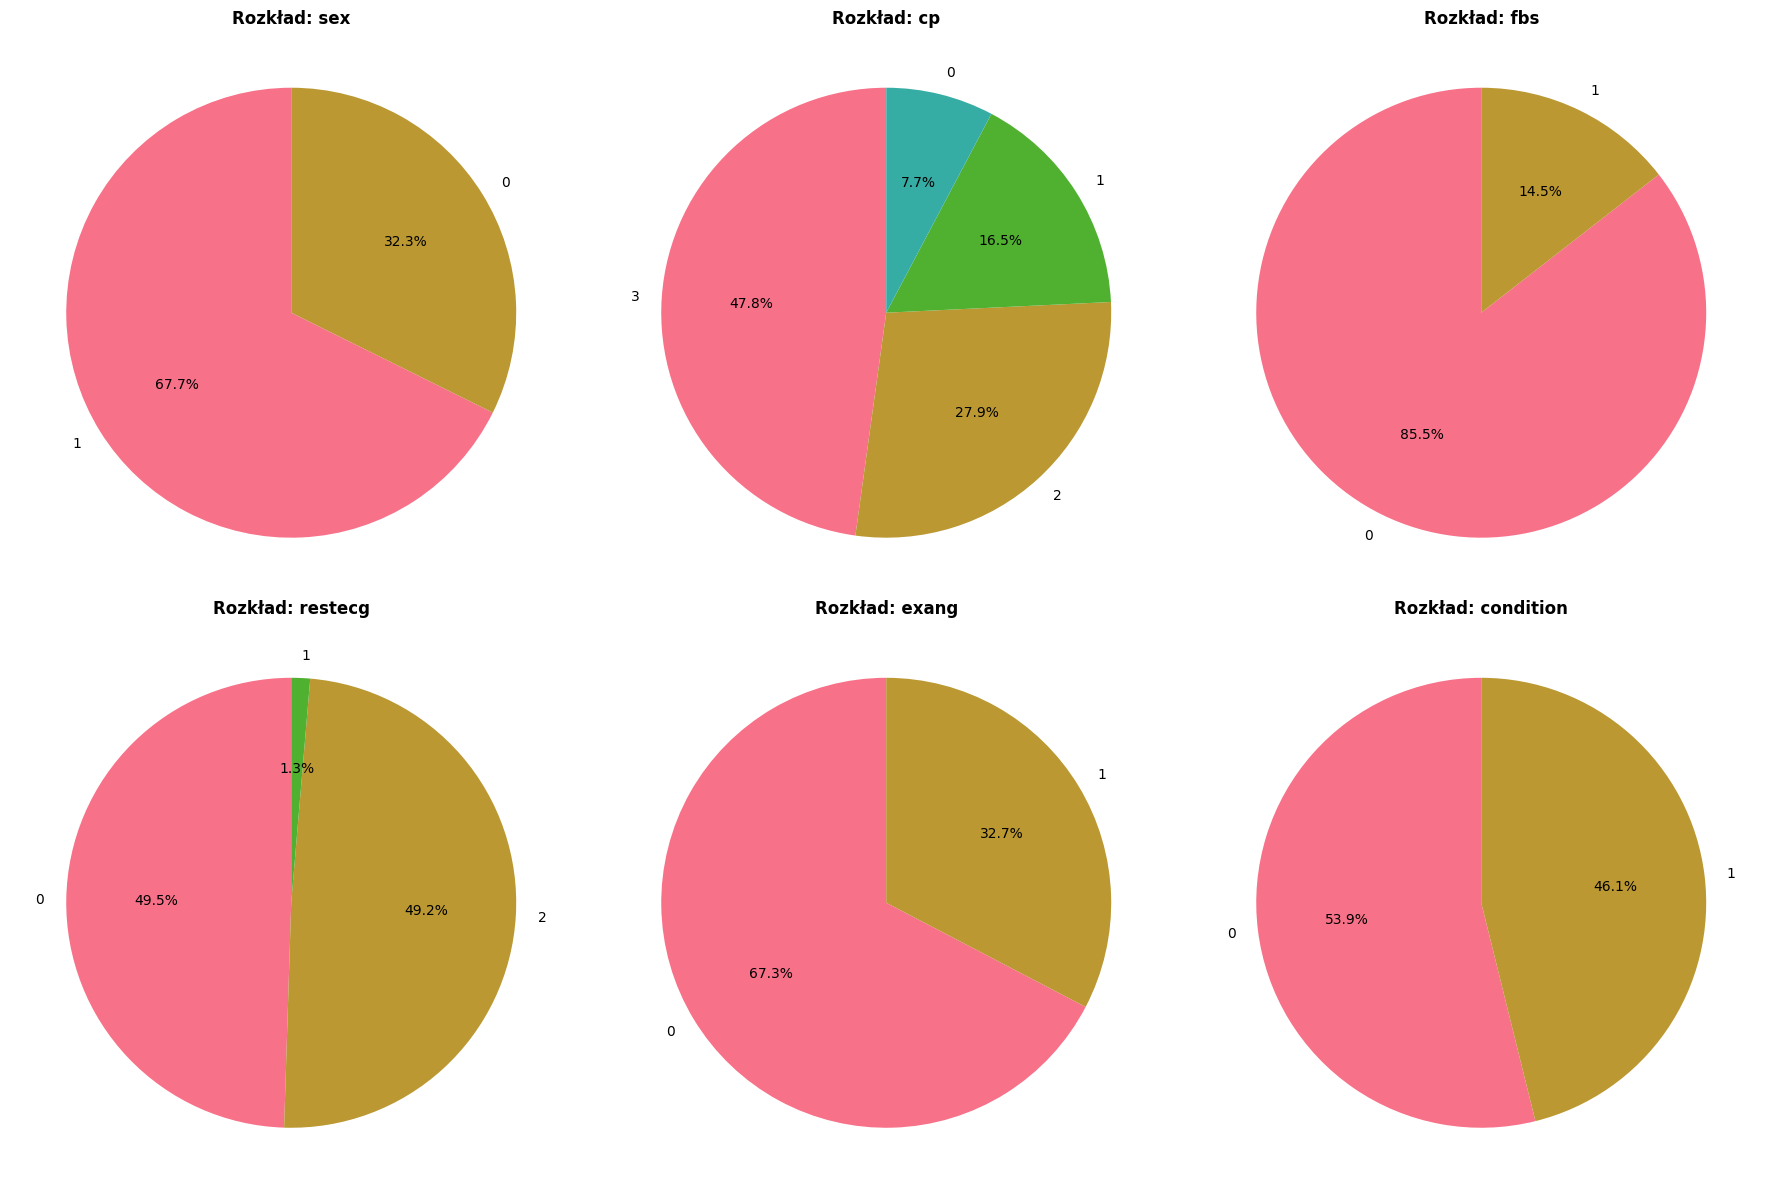

In [9]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'condition']
for idx, col in enumerate(categorical_cols):
    if col in df_clean.columns and idx < len(axes):
        ax = axes[idx]
        value_counts = df_clean[col].value_counts()
        ax.pie(value_counts.values, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
        ax.set_title(f'Rozkład: {col}', fontweight='bold')

for idx in range(len([c for c in categorical_cols if c in df_clean.columns]), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### 7.2 Wykresy słupkowe - liczebność w klasach


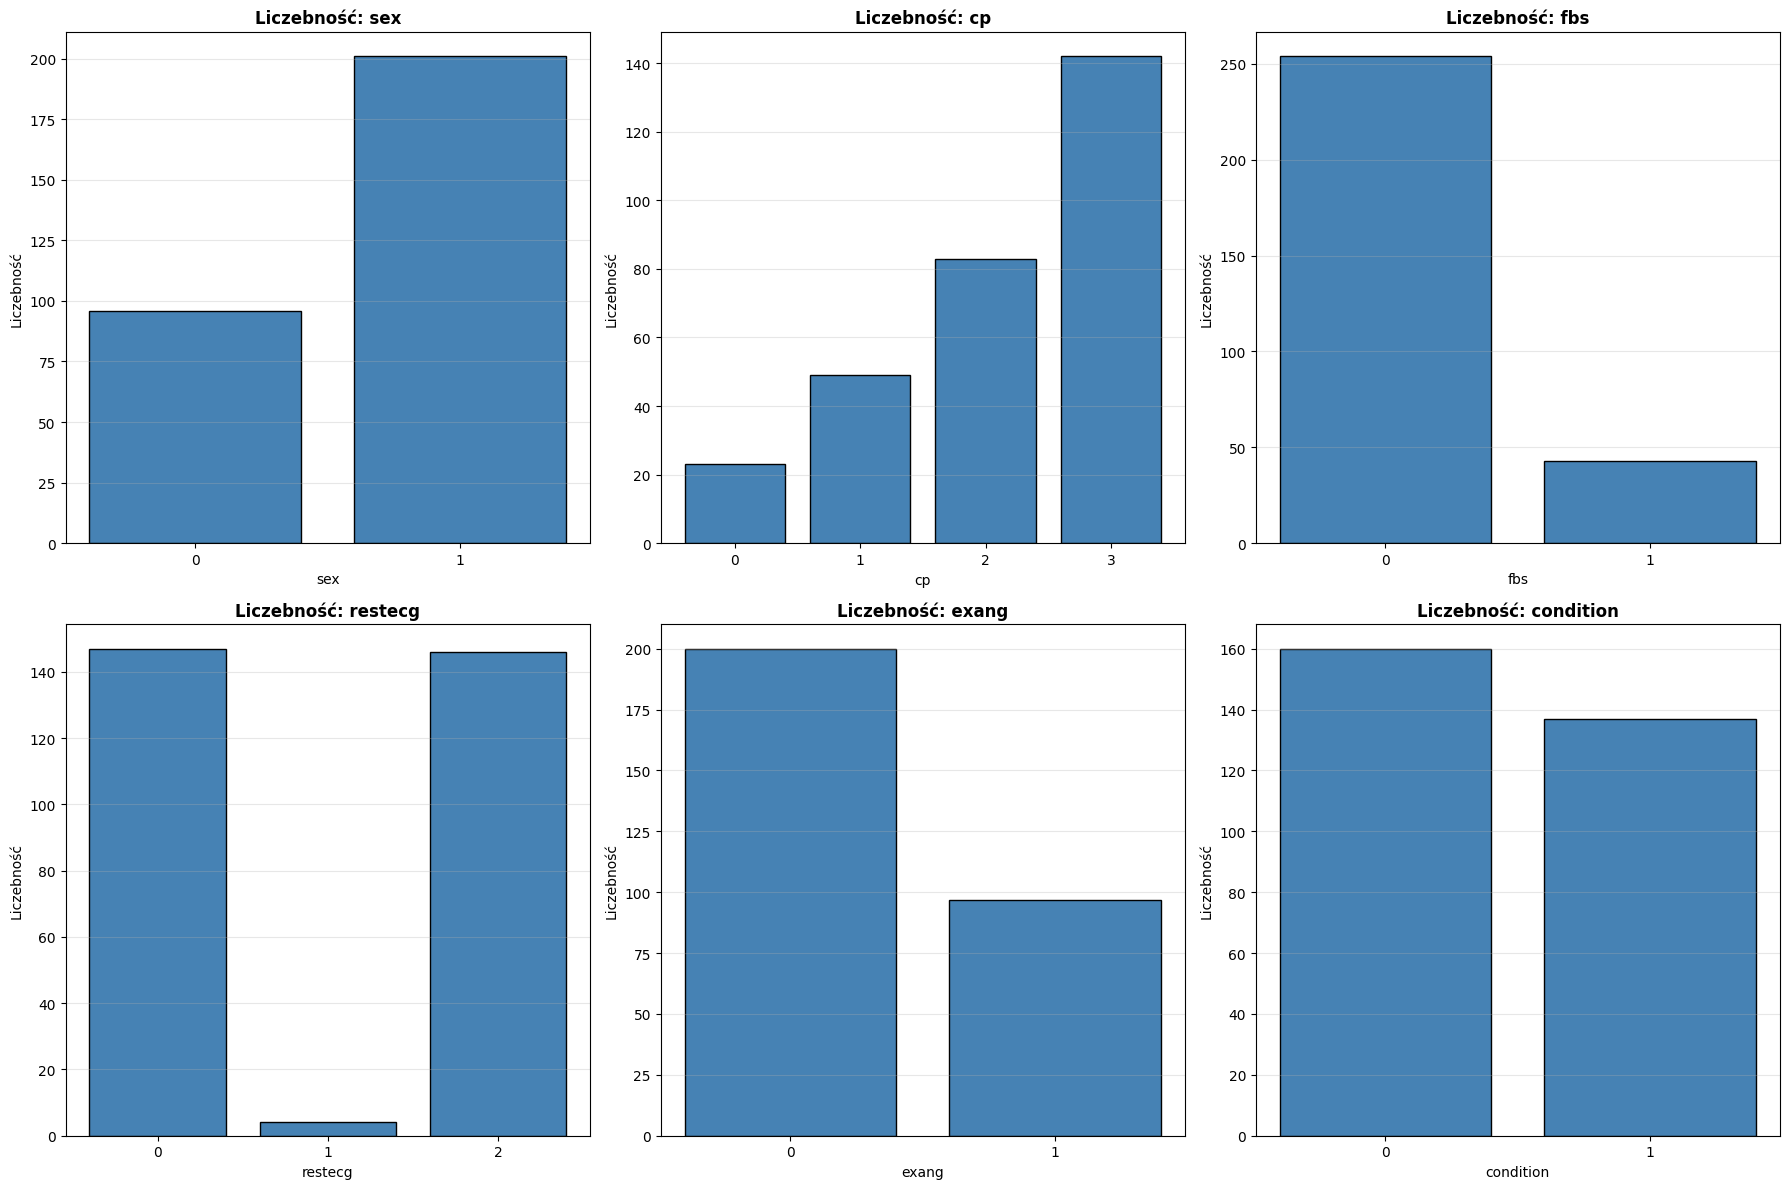

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'condition']
for idx, col in enumerate(categorical_cols):
    if col in df_clean.columns and idx < len(axes):
        ax = axes[idx]
        value_counts = df_clean[col].value_counts().sort_index()
        ax.bar(range(len(value_counts)), value_counts.values, color='steelblue', edgecolor='black')
        ax.set_xticks(range(len(value_counts)))
        ax.set_xticklabels(value_counts.index)
        ax.set_xlabel(col)
        ax.set_ylabel('Liczebność')
        ax.set_title(f'Liczebność: {col}', fontweight='bold')
        ax.grid(axis='y', alpha=0.3)

for idx in range(len([c for c in categorical_cols if c in df_clean.columns]), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### 7.3 Histogramy zmiennych


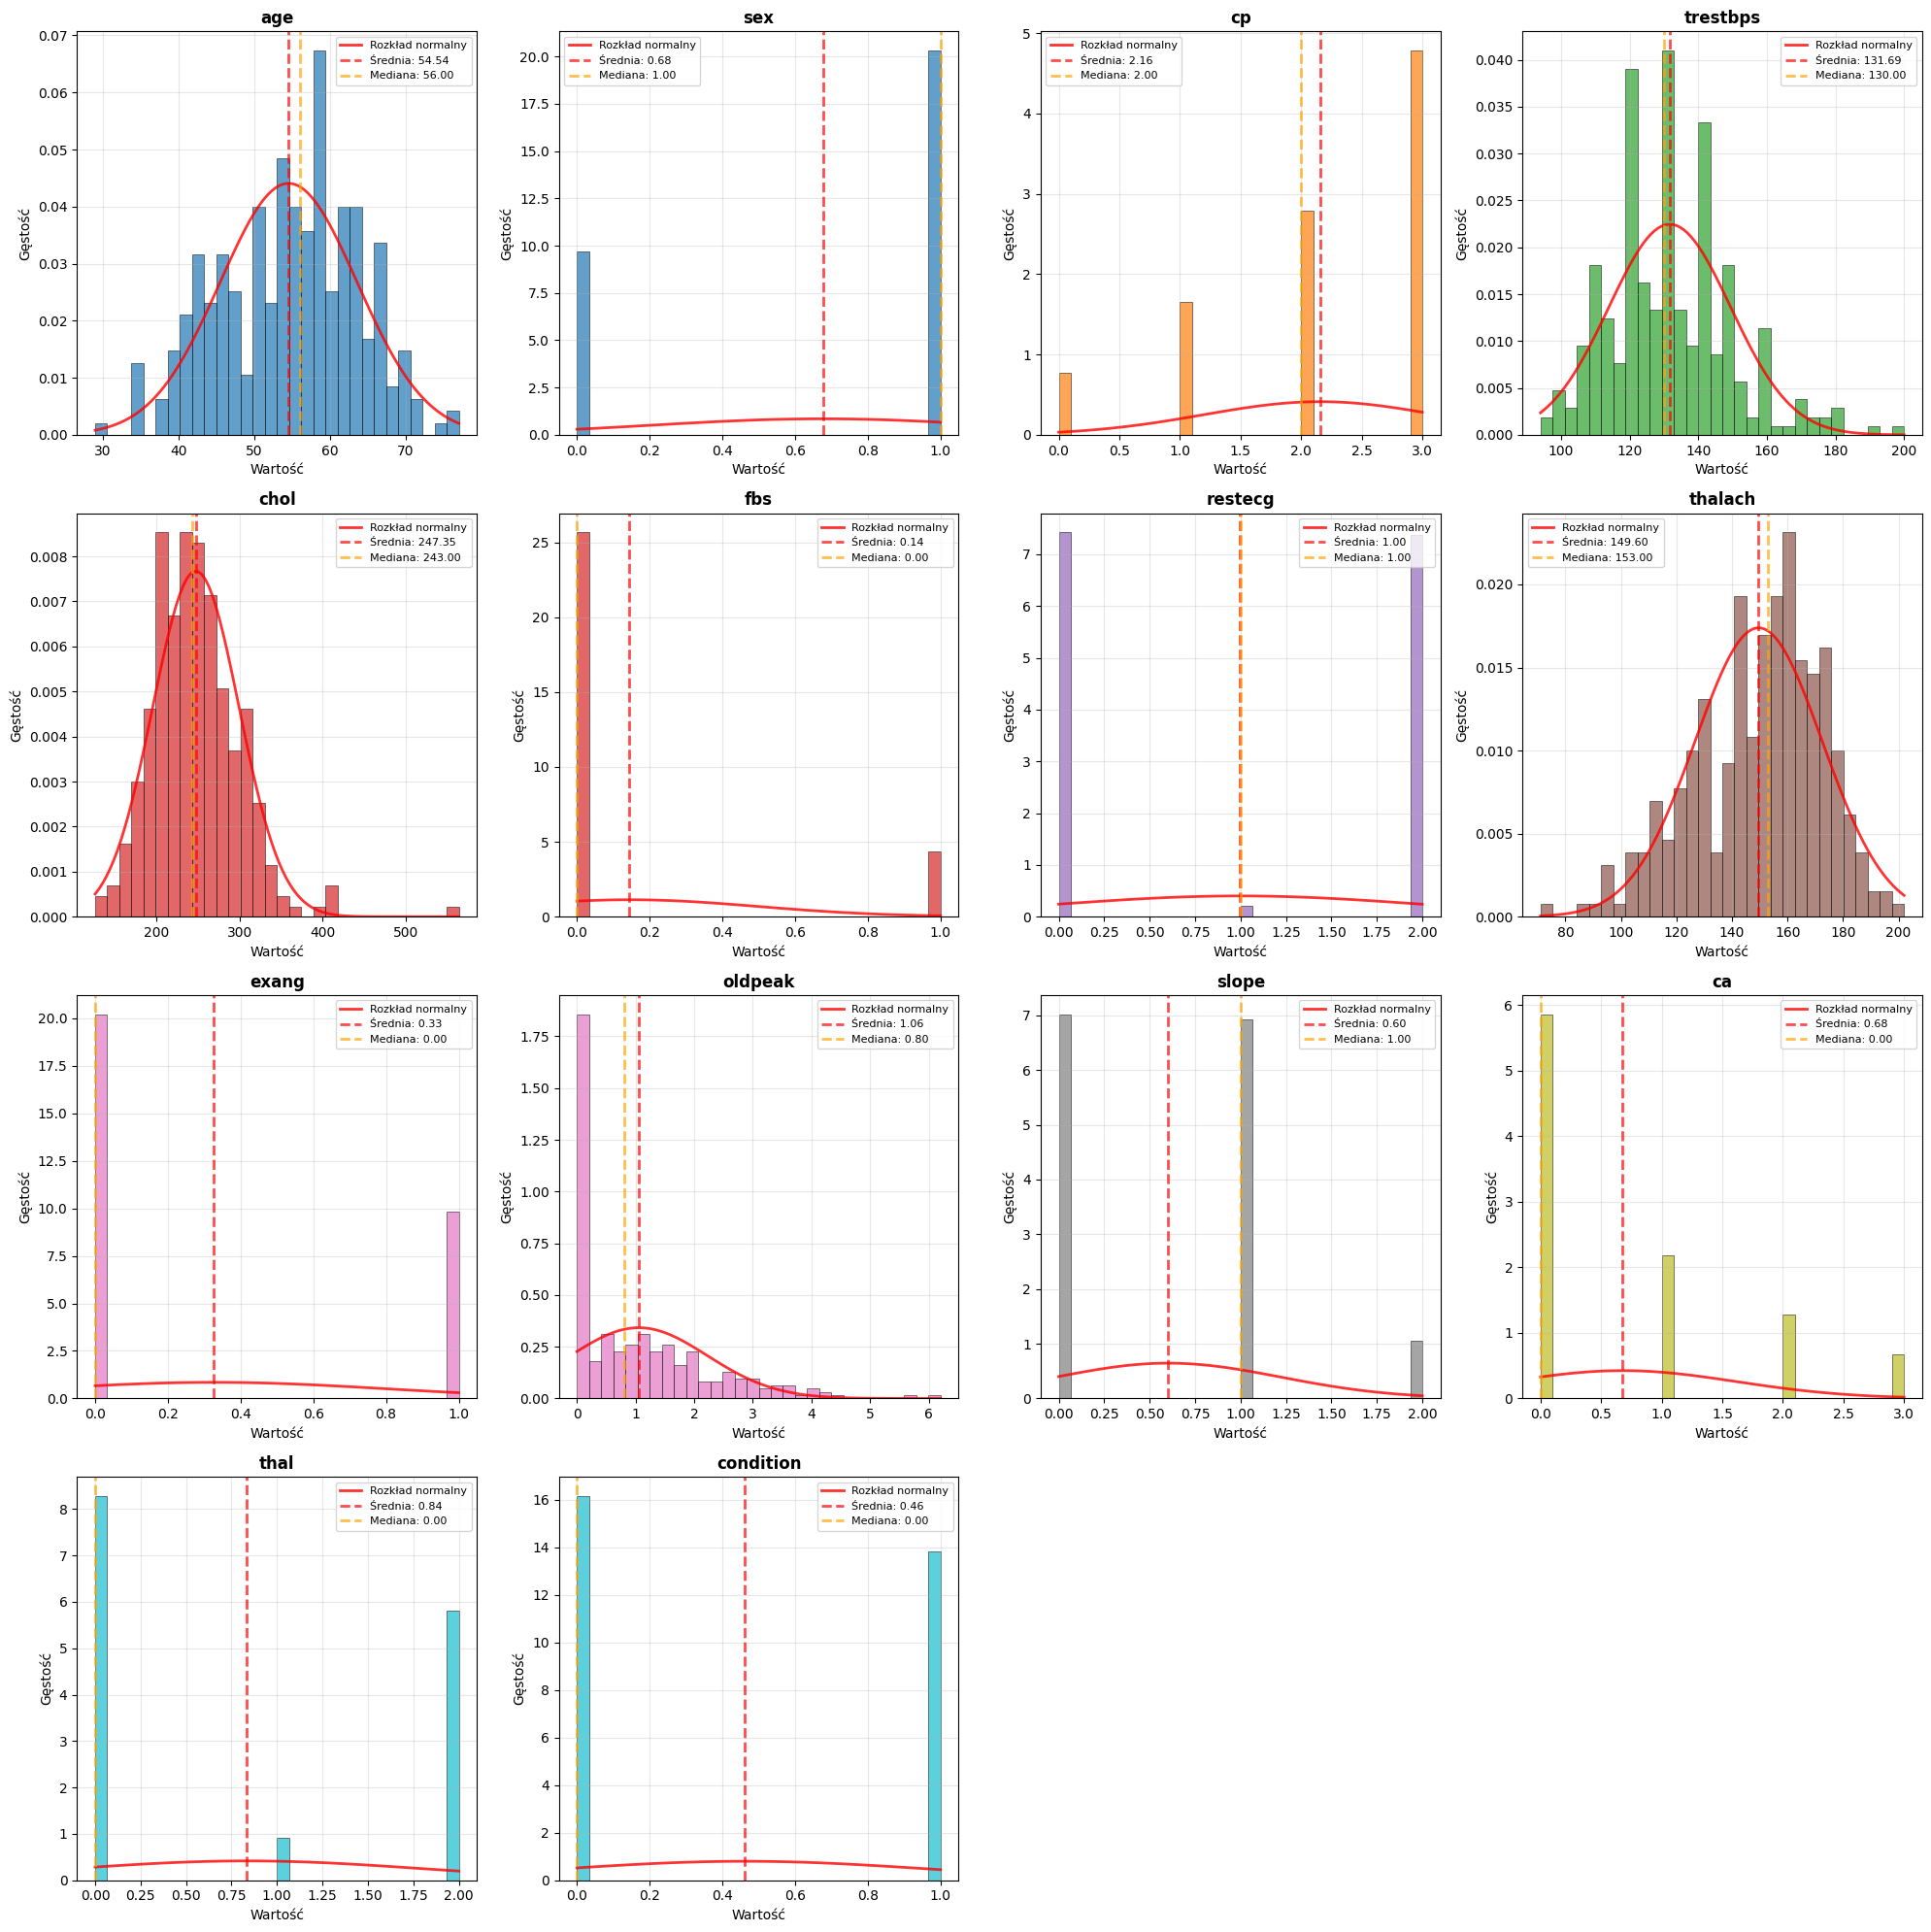

In [11]:
def create_histograms(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    n_cols = 4
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

    colors = plt.cm.tab10(np.linspace(0, 1, len(numeric_cols)))

    for i, (column, color) in enumerate(zip(numeric_cols, colors)):
        axes[i].hist(df[column], bins=30, density=True, alpha=0.7,
                    color=color, edgecolor='black', linewidth=0.5)

        x = np.linspace(df[column].min(), df[column].max(), 100)
        mean = df[column].mean()
        std = df[column].std()
        normal_curve = (1/(std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std) ** 2)

        axes[i].plot(x, normal_curve, 'r-', linewidth=2, alpha=0.8, label='Rozkład normalny')
        axes[i].axvline(mean, color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Średnia: {mean:.2f}')
        axes[i].axvline(df[column].median(), color='orange', linestyle='--', linewidth=2, alpha=0.7, label=f'Mediana: {df[column].median():.2f}')

        axes[i].set_title(f'{column}', fontsize=12, fontweight='bold')
        axes[i].set_xlabel('Wartość')
        axes[i].set_ylabel('Gęstość')
        axes[i].legend(fontsize=8)
        axes[i].grid(True, alpha=0.3)

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

create_histograms(df_clean)

### 7.4 Wykresy pudełkowe (boxplots)


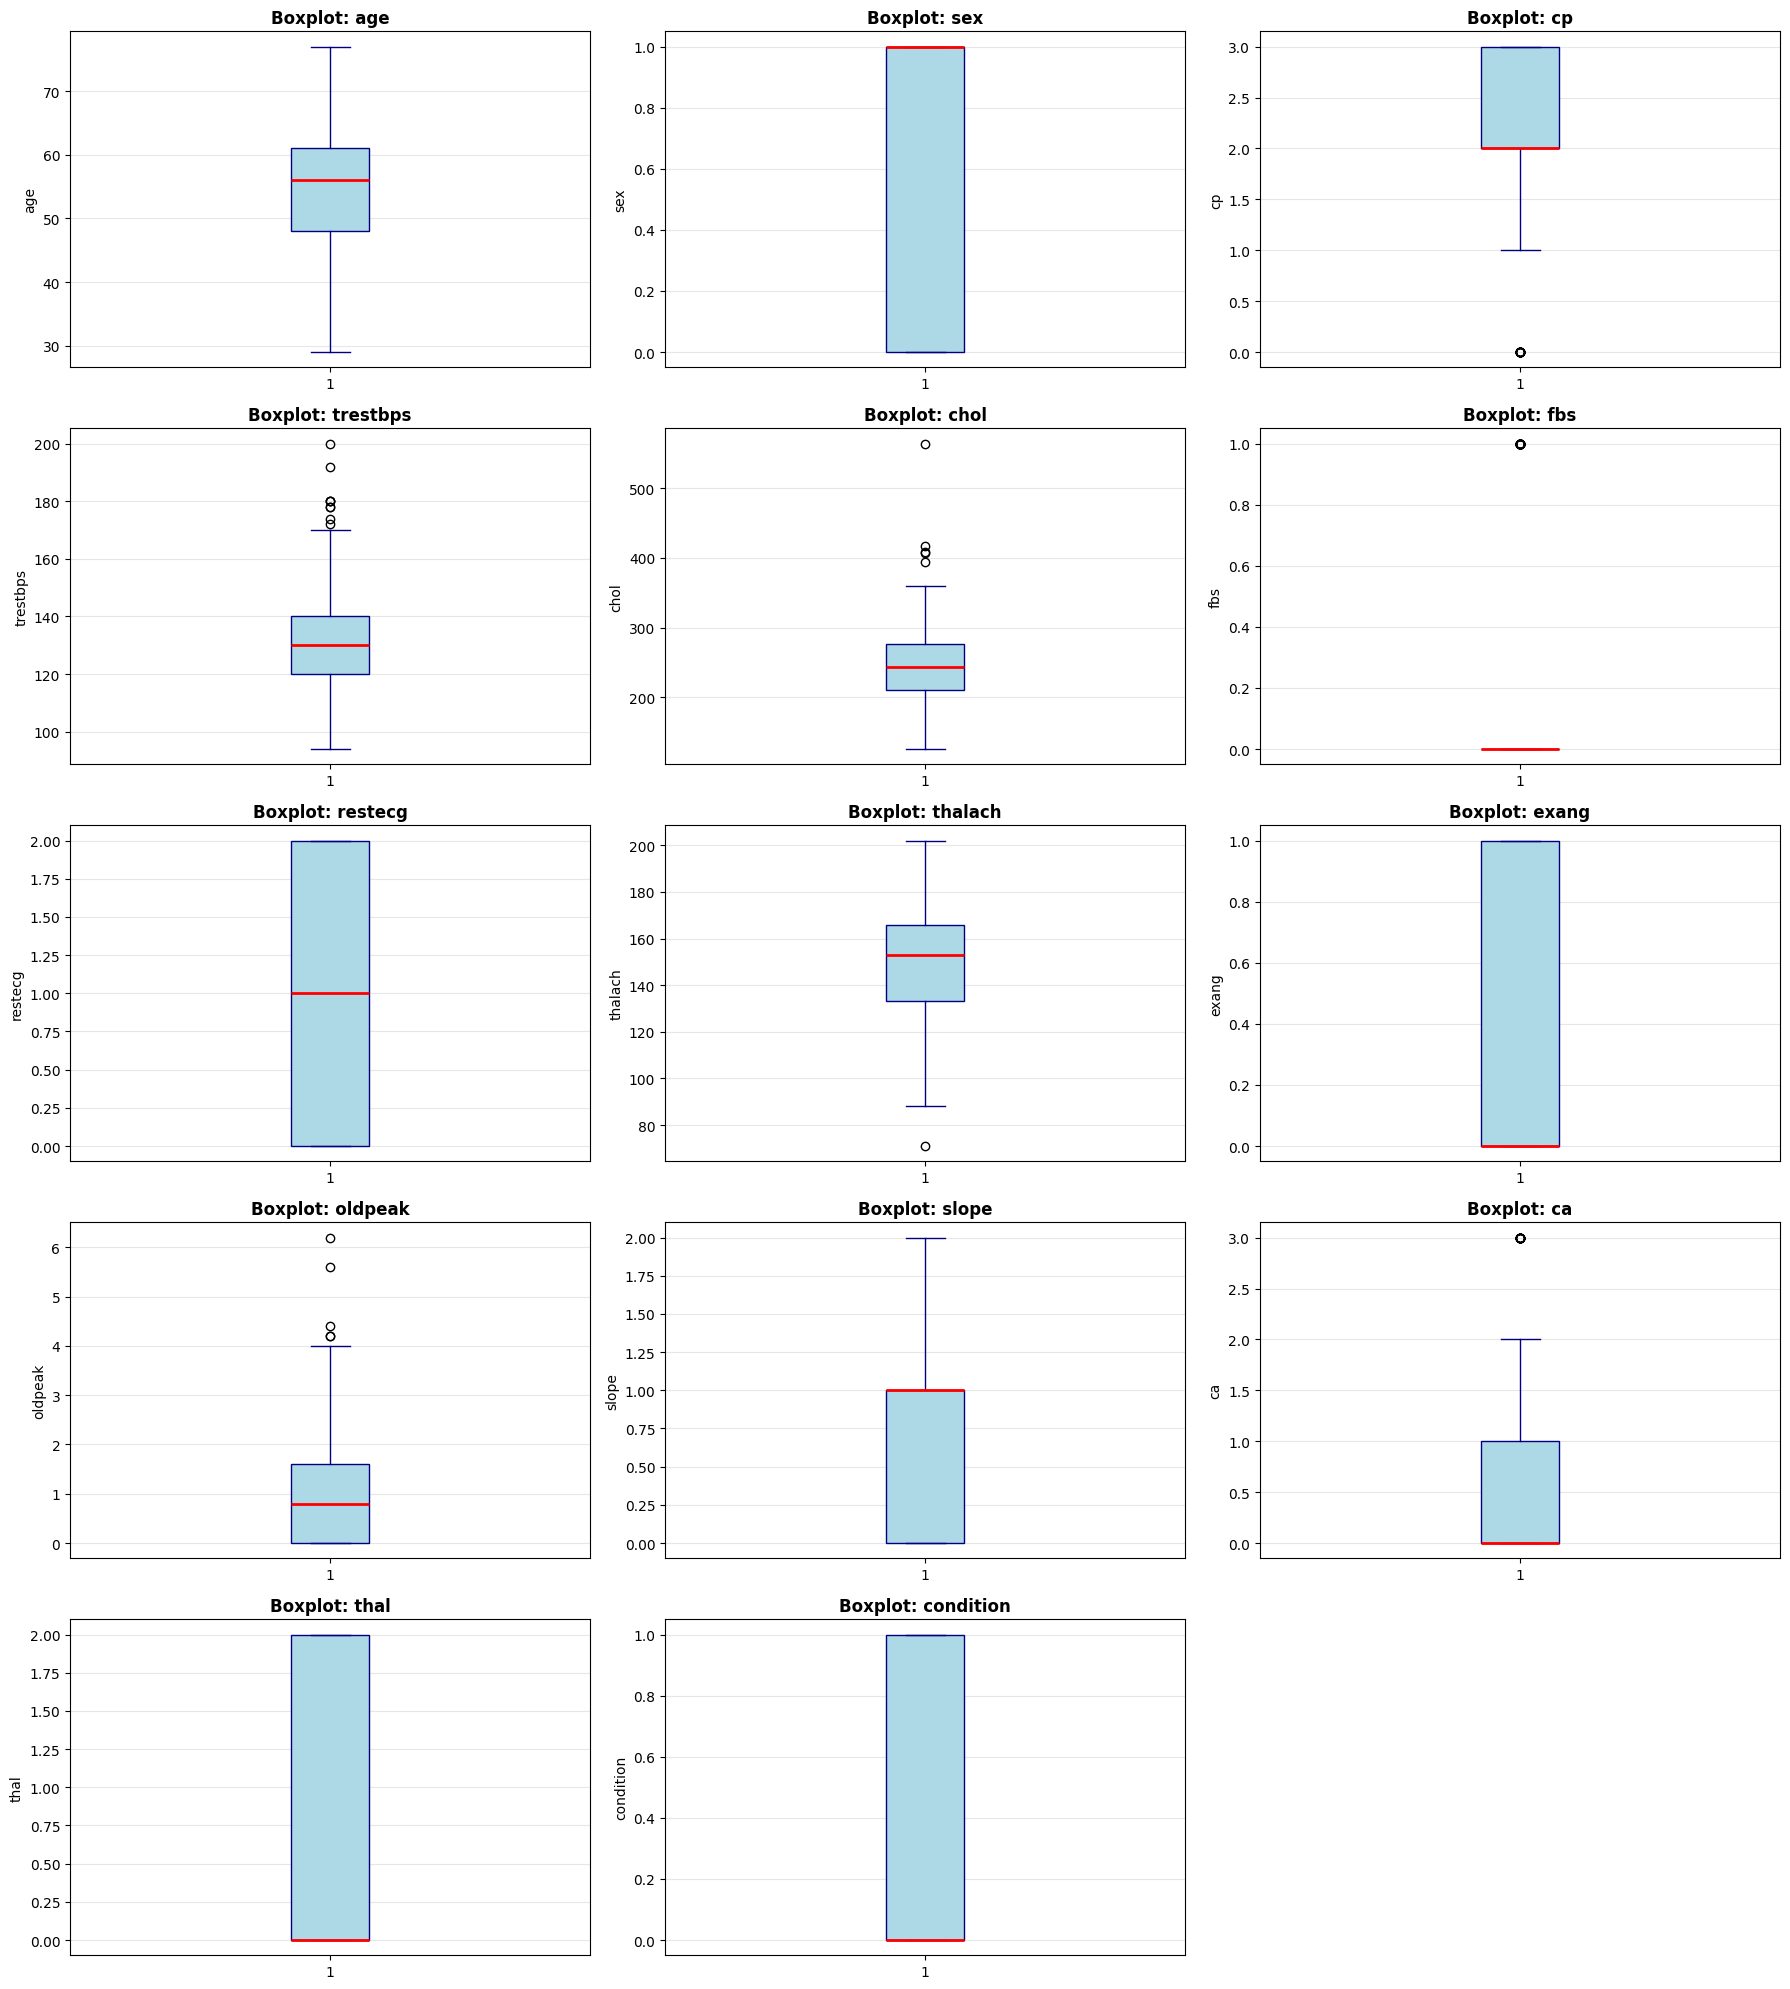

In [12]:
def create_boxplots(df):
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    n_cols = 3
    n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 4))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

    for idx, col in enumerate(numeric_cols):
        axes[idx].boxplot(df[col].dropna(), vert=True, patch_artist=True,
                   boxprops=dict(facecolor='lightblue', color='navy'),
                   medianprops=dict(color='red', linewidth=2),
                   whiskerprops=dict(color='navy'),
                   capprops=dict(color='navy'))
        axes[idx].set_ylabel(col)
        axes[idx].set_title(f'Boxplot: {col}', fontweight='bold')
        axes[idx].grid(axis='y', alpha=0.3)

    for j in range(idx+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

create_boxplots(df_clean)

### 7.5 Wykresy wiolinowe (violin plots)


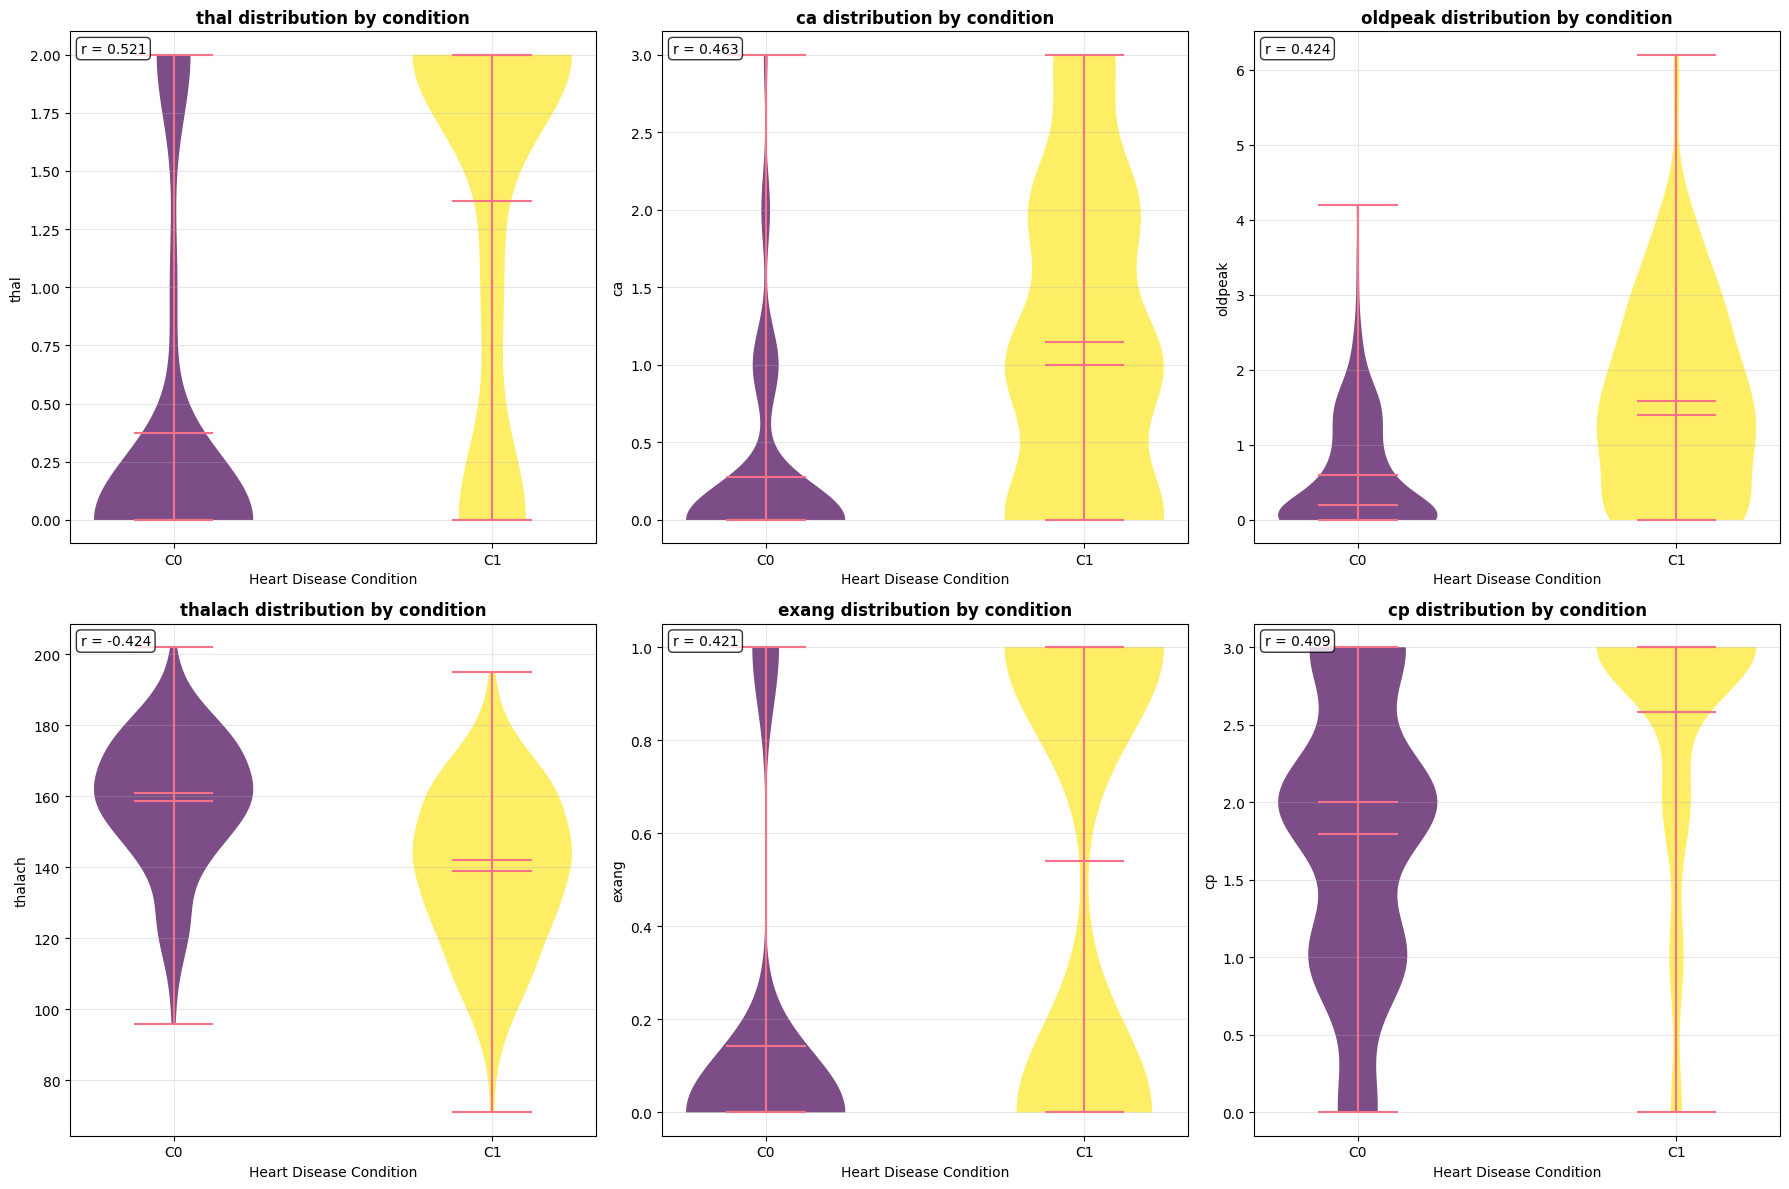

In [13]:
def create_violin_plots(df):
    numeric_columns = [col for col in df.select_dtypes(include=[np.number]).columns if col != 'condition']
    condition_levels = sorted(df['condition'].unique())

    correlations = df[numeric_columns].corrwith(df['condition']).abs().sort_values(ascending=False)
    top_variables = correlations.head(6).index.tolist()

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()

    for i, variable in enumerate(top_variables):
        data_for_violin = []
        labels_for_violin = []

        for condition in condition_levels:
            subset_data = df[df['condition'] == condition][variable].values
            if len(subset_data) > 5:
                data_for_violin.append(subset_data)
                labels_for_violin.append(f'C{condition}')

        parts = axes[i].violinplot(data_for_violin, positions=range(1, len(data_for_violin)+1),
                                  showmeans=True, showextrema=True, showmedians=True)

        colors = plt.cm.viridis(np.linspace(0, 1, len(data_for_violin)))
        for pc, color in zip(parts['bodies'], colors):
            pc.set_facecolor(color)
            pc.set_alpha(0.7)

        axes[i].set_title(f'{variable} distribution by condition', fontweight='bold')
        axes[i].set_xlabel('Heart Disease Condition')
        axes[i].set_ylabel(variable)
        axes[i].set_xticks(range(1, len(labels_for_violin)+1))
        axes[i].set_xticklabels(labels_for_violin)
        axes[i].grid(alpha=0.3)

        correlation_with_condition = df[variable].corr(df['condition'])
        axes[i].text(0.02, 0.98, f'r = {correlation_with_condition:.3f}',
                    transform=axes[i].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

create_violin_plots(df_clean)

### 7.6 Wykresy rozrzutu z regresją liniową


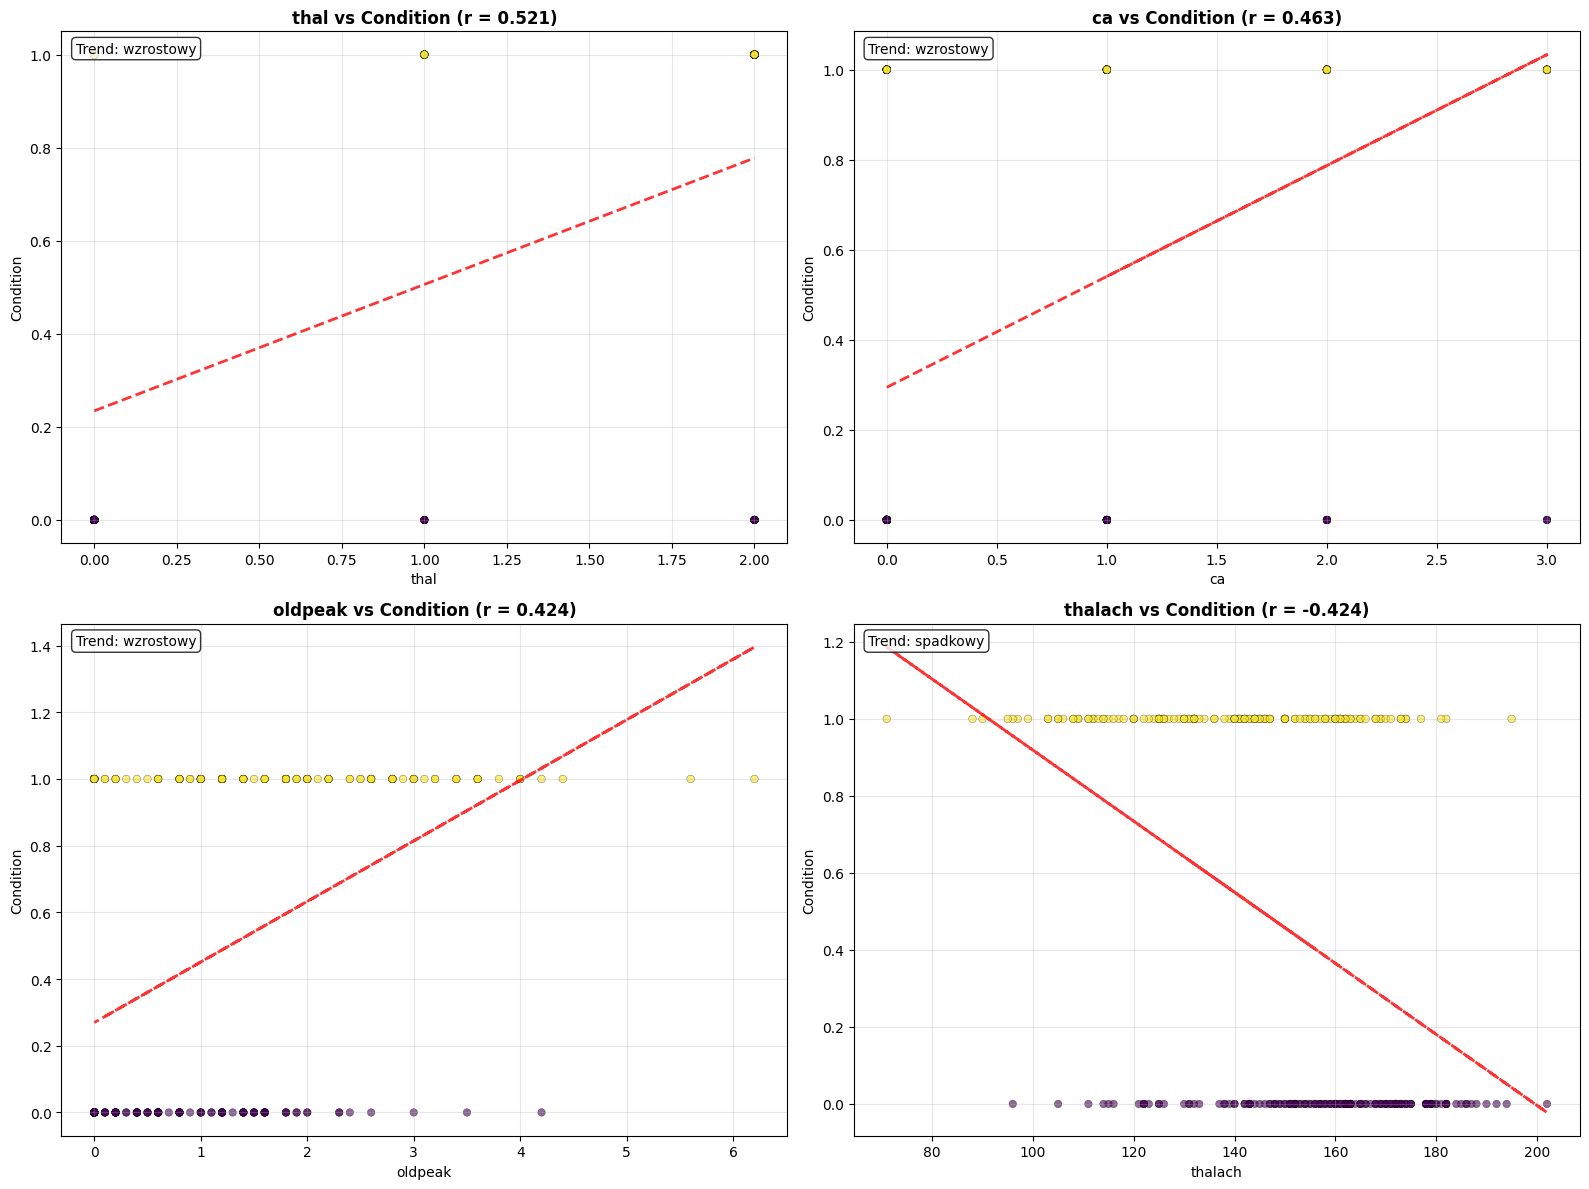

In [14]:
def create_scatter_plots(df):
    numeric_columns = [col for col in df.select_dtypes(include=[np.number]).columns if col != 'condition']

    correlations_with_condition = df[numeric_columns].corrwith(df['condition']).abs().sort_values(ascending=False)
    top_4_variables = correlations_with_condition.head(4).index.tolist()

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()

    for i, variable in enumerate(top_4_variables):
        scatter = axes[i].scatter(df[variable], df['condition'],
                                 c=df['condition'], cmap='viridis',
                                 alpha=0.6, s=30, edgecolors='black', linewidth=0.3)

        z = np.polyfit(df[variable], df['condition'], 1)
        p = np.poly1d(z)
        axes[i].plot(df[variable], p(df[variable]), "r--", alpha=0.8, linewidth=2)

        correlation = df[variable].corr(df['condition'])
        axes[i].set_title(f'{variable} vs Condition (r = {correlation:.3f})', fontweight='bold')
        axes[i].set_xlabel(variable)
        axes[i].set_ylabel('Condition')
        axes[i].grid(True, alpha=0.3)

        axes[i].text(0.02, 0.98, f'Trend: {"wzrostowy" if correlation > 0 else "spadkowy"}',
                    transform=axes[i].transAxes, verticalalignment='top',
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

create_scatter_plots(df_clean)

### 7.7 Mapa ciepła korelacji


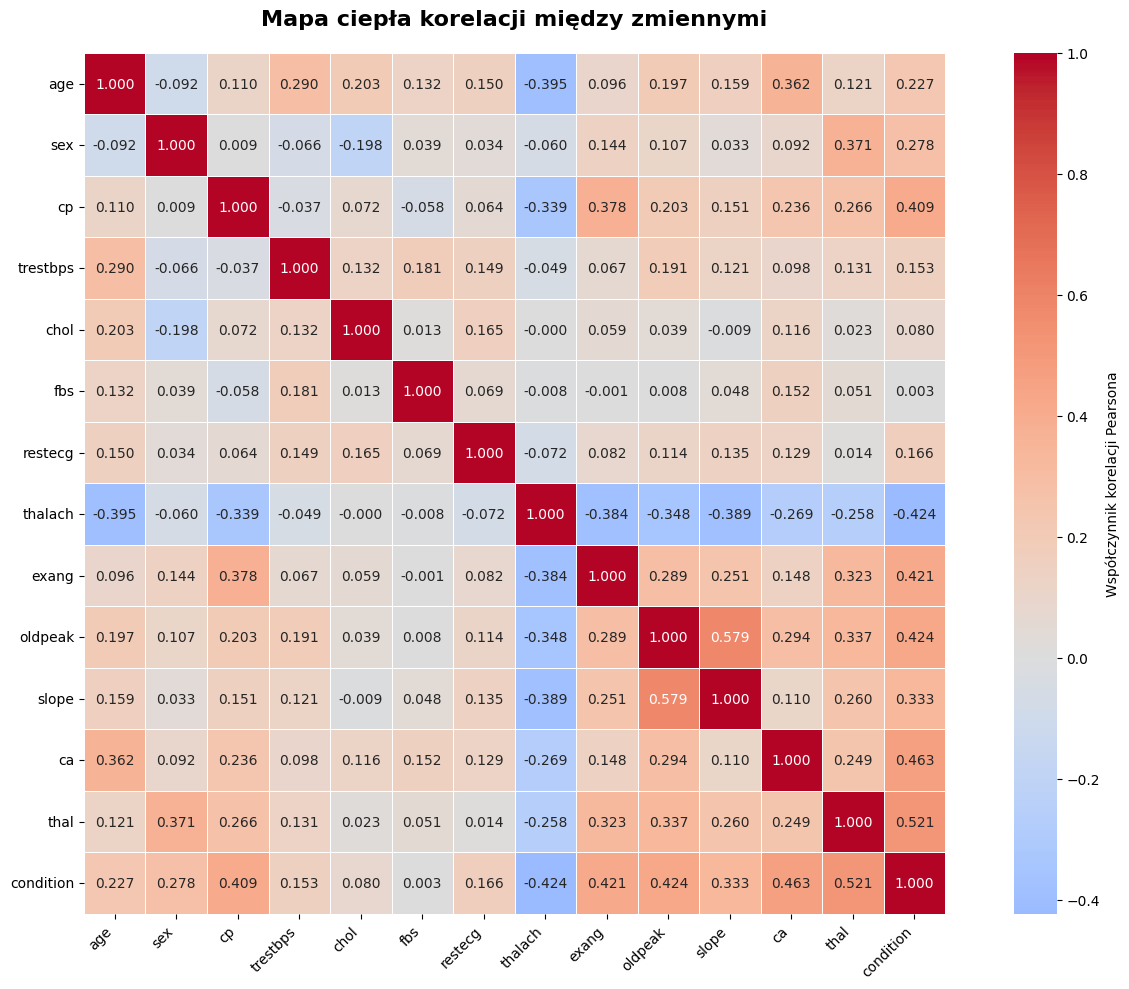

In [15]:
def create_correlation_heatmap(df):
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    correlation_matrix = df[numeric_columns].corr()

    plt.figure(figsize=(14, 10))

    heatmap = sns.heatmap(correlation_matrix,
                         annot=True,
                         cmap='coolwarm',
                         center=0,
                         square=True,
                         fmt='.3f',
                         cbar_kws={'label': 'Współczynnik korelacji Pearsona'},
                         linewidths=0.5)

    plt.title('Mapa ciepła korelacji między zmiennymi', fontsize=16, fontweight='bold', pad=20)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

create_correlation_heatmap(df_clean)

## 8. Podsumowanie analizy


In [16]:
def generate_comprehensive_summary(df, correlation_matrix, descriptive_stats):
    print("=" * 80)
    print("KOMPLEKSOWE PODSUMOWANIE ANALIZY CHORÓB SERCA")
    print("=" * 80)

    print(f"\n1. PODSTAWOWE INFORMACJE O ZBIORZE DANYCH:")
    print(f"   • Liczba obserwacji: {len(df)}")
    print(f"   • Liczba zmiennych: {df.shape[1]}")
    print(f"   • Zakres stopnia choroby: {df['condition'].min()} - {df['condition'].max()}")
    print(f"   • Średni stopień: {df['condition'].mean():.2f} ± {df['condition'].std():.2f}")

    print(f"\n2. JAKOŚĆ DANYCH:")
    missing_data = df.isnull().sum().sum()
    duplicates = df.duplicated().sum()
    print(f"   • Brakujące wartości: {missing_data} (0.0%)")
    print(f"   • Duplikaty: {duplicates}")
    print(f"   • Status danych: {'Czyste' if missing_data == 0 and duplicates == 0 else 'Wymagają czyszczenia'}")

    print(f"\n3. KLUCZOWE STATYSTYKI OPISOWE:")
    numeric_columns = df.select_dtypes(include=[np.number]).columns

    for column in list(numeric_columns)[:3]:
        if column in df.columns:
            mean_val = df[column].mean()
            std_val = df[column].std()
            median_val = df[column].median()
            print(f"   • {column}: średnia = {mean_val:.2f}, mediana = {median_val:.2f}, σ = {std_val:.2f}")

    print(f"\n4. ANALIZA KORELACJI:")
    condition_corrs = df[numeric_columns].corrwith(df['condition']).abs().sort_values(ascending=False)

    print(f"   • Najsilniejsze predyktory stopnia choroby:")
    for i, (var, corr) in enumerate(condition_corrs.head(5).items()):
        if var != 'condition':
            direction = "dodatnia" if df[var].corr(df['condition']) > 0 else "ujemna"
            strength = "bardzo silna" if corr > 0.7 else "silna" if corr > 0.5 else "umiarkowana" if corr > 0.3 else "słaba"
            print(f"     {i+1}. {var}: r = {df[var].corr(df['condition']):.3f} ({direction}, {strength})")

    print(f"\n   • Najsilniejsze korelacje między zmiennymi:")
    strong_pairs = []
    for i, col1 in enumerate(numeric_columns):
        for j, col2 in enumerate(numeric_columns):
            if i < j and col1 != 'condition' and col2 != 'condition':
                corr = correlation_matrix.loc[col1, col2]
                if abs(corr) > 0.5:
                    strong_pairs.append((col1, col2, corr))

    strong_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

    if strong_pairs:
        for col1, col2, corr in strong_pairs[:3]:
            print(f"     • {col1} ↔ {col2}: r = {corr:.3f}")
    else:
        print(f"     • Brak silnych korelacji między zmiennymi (|r| > 0.5)")

    print(f"\n5. PRZYGOTOWANIE DO MODELOWANIA ML:")
    feature_ranking = [(col, abs(df[col].corr(df['condition'])), df[col].corr(df['condition']))
                      for col in numeric_columns if col != 'condition']
    feature_ranking.sort(key=lambda x: x[1], reverse=True)

    best_predictors = [x[0] for x in feature_ranking[:3]]
    print(f"   • Top 3 cechy dla XGBoost/Random Forest:")
    for i, (predictor, abs_corr, corr) in enumerate(feature_ranking[:3], 1):
        print(f"     {i}. {predictor}: r = {corr:.3f}")

    print(f"\n6. ROZKŁADY ZMIENNYCH:")
    print(f"   • Analiza normalności (test Shapiro-Wilk):")
    normal_vars = []
    non_normal_vars = []

    for column in numeric_columns:
        if len(df) <= 5000:
            _, p_value = stats.shapiro(df[column].sample(min(1000, len(df))))
        else:
            _, p_value = stats.kstest(df[column], 'norm',
                                    args=(df[column].mean(), df[column].std()))

        if p_value > 0.05:
            normal_vars.append(column)
        else:
            non_normal_vars.append(column)

    print(f"     Rozkład normalny ({len(normal_vars)}): {', '.join(normal_vars) if normal_vars else 'Brak'}")
    print(f"     Rozkład nienormalny ({len(non_normal_vars)}): {', '.join(non_normal_vars[:3]) + ('...' if len(non_normal_vars) > 3 else '')}")

    print(f"\n7. WARTOŚCI ODSTAJĄCE:")
    total_outliers = 0
    for column in numeric_columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        outliers = df[(df[column] < Q1 - 1.5 * IQR) | (df[column] > Q3 + 1.5 * IQR)]
        total_outliers += len(outliers)

    outlier_percentage = (total_outliers / (len(df) * len(numeric_columns))) * 100
    print(f"   • Procent wartości odstających: {outlier_percentage:.1f}%")
    print(f"   • Status: {'Normalny' if outlier_percentage < 5 else 'Podwyższony' if outlier_percentage < 10 else 'Wysoki'} poziom wartości ekstremalnych")

    print(f"\n8. WNIOSKI I REKOMENDACJE:")
    print(f"   ✓ Zbiór danych jest kompletny i gotowy do analizy")
    print(f"   ✓ Wykonano prostą regresję liniową z wzorami matematycznymi")
    print(f"   ✓ Zidentyfikowano kluczowe predyktory stopnia choroby serca")
    print(f"   ✓ Dane przygotowane do modelowania XGBoost/Random Forest")
    print(f"   ✓ Kompleksowa analiza statystyczna i wizualizacja zakończona")

    print(f"\n" + "=" * 80)
    print("ANALIZA ZAKOŃCZONA POMYŚLNIE")
    print("=" * 80)

correlation_heatmap = df_clean.select_dtypes(include=[np.number]).corr()
generate_comprehensive_summary(df_clean, correlation_heatmap, descriptive_stats)

KOMPLEKSOWE PODSUMOWANIE ANALIZY CHORÓB SERCA

1. PODSTAWOWE INFORMACJE O ZBIORZE DANYCH:
   • Liczba obserwacji: 297
   • Liczba zmiennych: 14
   • Zakres stopnia choroby: 0 - 1
   • Średni stopień: 0.46 ± 0.50

2. JAKOŚĆ DANYCH:
   • Brakujące wartości: 0 (0.0%)
   • Duplikaty: 0
   • Status danych: Czyste

3. KLUCZOWE STATYSTYKI OPISOWE:
   • age: średnia = 54.54, mediana = 56.00, σ = 9.05
   • sex: średnia = 0.68, mediana = 1.00, σ = 0.47
   • cp: średnia = 2.16, mediana = 2.00, σ = 0.96

4. ANALIZA KORELACJI:
   • Najsilniejsze predyktory stopnia choroby:
     2. thal: r = 0.521 (dodatnia, silna)
     3. ca: r = 0.463 (dodatnia, umiarkowana)
     4. oldpeak: r = 0.424 (dodatnia, umiarkowana)
     5. thalach: r = -0.424 (ujemna, umiarkowana)

   • Najsilniejsze korelacje między zmiennymi:
     • oldpeak ↔ slope: r = 0.579

5. PRZYGOTOWANIE DO MODELOWANIA ML:
   • Top 3 cechy dla XGBoost/Random Forest:
     1. thal: r = 0.521
     2. ca: r = 0.463
     3. oldpeak: r = 0.424

6. ROZK